## MNIST Classification / Generation using AUNN


Notes: 

Probably there's two ways to do this
1. By creating a purely binary output layer, binarizing MNIST images, and having classification labels be a one-hot encoding appended to the end
2. Having an output dimension of 1+num_classes, encoding binary mnist purely in the 1st dimension, and outputing class after the image via other dimensions.

I think I'll initially go with method 1 because having a single dimensional output feels simpler, but can always change later on if needed. Also, to the extent that's possible, we probably want images and labels aligned to borders that are powers of 2, since that'll likely make detecting structural patterns much easier for the network.

In [1]:
import torch
import random
import torch.optim as optim
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#deallocate all cuda memory
torch.cuda.empty_cache()

#print cuda memory
print(torch.cuda.memory_allocated())

cuda
0


In [2]:
# def positional_encoding(x: torch.Tensor, dim: int = 64):
#     """Apply fourier positional encoding to the input.

#     Args:
#       x (torch.Tensor): a 1 dimension tensor of indices
#       dim (optional, int): dimension of positional encoding. max index representable is 2^(dim//2+1). Default: 64.
#     Returns:
#       (torch.Tensor): Positional encoding of the input tensor. dimension: [x.size(0), dim]
#     """
#     position = x.unsqueeze(1)
#     device = x.device  # Get the device of x

#     # Create div_term on the same device as x
#     div_term = torch.exp(
#         torch.arange(0, dim, 2, dtype=torch.float32, device=device) *\
#             (-np.log(10000.0) / dim)
#     )

#     # Create pe on the same device as x
#     pe = torch.zeros(x.size(0), dim, device=device)

#     # Perform computations
#     pe[:, 0::2] = torch.sin(position * div_term)
#     pe[:, 1::2] = torch.cos(position * div_term)
#     return pe


# def positional_encoding(x, dim: int = 48):
#     """
#     Binary positional encoding, where each dimension is a bit in the binary representation of the index.
    
#     Args:
#         x: Input tensor of positions with shape [N]
#         dim (int): Number of bits in the binary encoding (output dimension). Default is 48.

#     Returns:
#         torch.Tensor: A binary encoding tensor with shape [N, dim] where each bit represents a binary position.
#     """

#     # Each row corresponds to an element in x; columns are the binary bits
#     encoding = ((x.unsqueeze(1) >> torch.arange(dim, device=x.device)) & 1).to(torch.float32)

#     return encoding


def positional_encoding(x: torch.Tensor, dim: int = 128):
    """
    Positional encoding using sine and cosine functions with frequencies as powers of two,
    starting from 2^2 (i.e., skipping 2^0 and 2^1).

    Args:
        x (torch.Tensor): Input tensor of positions with shape [N]
        dim (int): Total dimension of the encoding. Must be even.

    Returns:
        torch.Tensor: A tensor with shape [N, dim] containing the positional encodings.
    """
    assert dim % 2 == 0, "Encoding dimension (dim) must be even."

    # Determine the number of frequencies
    num_frequencies = dim // 2

    # Frequencies corresponding to powers of two, starting from 2^2
    frequency_powers = torch.arange(2, 2 + num_frequencies, dtype=torch.float32, device=x.device)
    frequencies = 2 ** frequency_powers  # Shape: [num_frequencies]

    # Compute the angles: [N, num_frequencies]
    x = x.unsqueeze(1)  # Shape: [N, 1]
    angles = (2 * torch.pi * x) / frequencies  # Broadcasting over x and frequencies

    # Compute the positional encodings
    encoding = torch.zeros(x.size(0), dim, device=x.device)
    encoding[:, 0::2] = torch.sin(angles)  # Even indices: sin
    encoding[:, 1::2] = torch.cos(angles)  # Odd indices: cos

    return encoding

In [3]:
class AUNNModel(nn.Module):
    def __init__(self, embedding_dim:int, output_dim:int, num_layers:int, hidden_dim:int):

        super(AUNNModel, self).__init__()
        
        assert num_layers % 2 == 0 and num_layers >= 2, "Number of layers must be even and at least 2."

        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # Input Layer
        self.input_layer = nn.Sequential(
            nn.Linear(self.embedding_dim, self.hidden_dim),
            nn.SiLU(),
            # nn.RMSNorm(self.hidden_dim)
        )

        # Hidden Layers
        self.layers = nn.ModuleList()
        for _ in range(self.num_layers - 2):  # Exclude input and output layers
            self.layers.append(nn.Sequential(
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.SiLU(),
                # nn.RMSNorm(self.hidden_dim)
            ))

        # Output Layer
        self.output_layer = nn.Linear(self.hidden_dim, self.output_dim)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Linear):
                # He initialization for Swish activation
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        
        output = self.input_layer(x)
        residual = output  # Initialize residual for skip connections

        for idx, layer in enumerate(self.layers):
            output = layer(output)

            # Apply skip connection every two layers
            if (idx + 1) % 2 == 0:
                output = output + residual  # Skip connection
                residual = output  # Update residual

        output = self.output_layer(output)
        return output

In [4]:
import struct
from array import array

def load_mnist(images_path, labels_path):

    labels = []
    with open(labels_path, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8)) 
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        labels = array("B", file.read())

    images = []
    rows, cols = None, None
    with open(images_path, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
        data = array("B", file.read())
        for i in range(size):
            img = np.array(data[i * rows * cols:(i + 1) * rows * cols], dtype=np.uint8)
            img = np.where(img > 0, 1, 0) #binarize
            img.resize((rows, cols))
            images.append(img)

    assert len(images) == len(labels)

    return images, labels

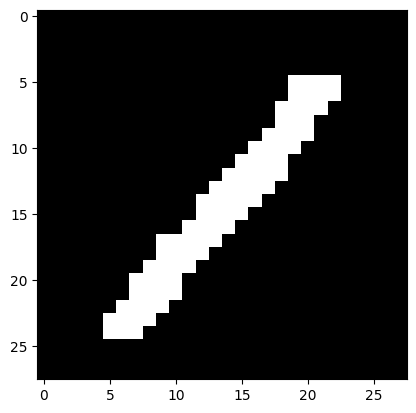

1
4000 784


In [5]:
from pathlib import Path

cur_dir = Path().resolve()
input_path = cur_dir / 'mnist'
training_images_filepath = input_path / 'train-images.idx3-ubyte'
training_labels_filepath = input_path /'train-labels.idx1-ubyte'
test_images_filepath = input_path / 't10k-images.idx3-ubyte'
test_labels_filepath = input_path / 't10k-labels.idx1-ubyte'

# images, labels = load_mnist(test_images_filepath, test_labels_filepath)
images, labels = load_mnist(training_images_filepath, training_labels_filepath)

keep_labels = [0,1,2,3] #DEBUG
label_inds = {}
for i, lbl in enumerate(labels):
    if lbl in keep_labels:
        if lbl not in label_inds:
            label_inds[lbl] = []
        if len(label_inds[lbl]) < 1000:
            label_inds[lbl].append(i)
indices = []
for lbl in keep_labels:
    indices.extend(label_inds[lbl])

random.seed(42)
random.shuffle(indices)

images = [images[i] for i in indices]
labels = [labels[i] for i in indices]

num_entries = len(images)
img_size = len(images[0].flatten())

plt.imshow(images[0], cmap='gray')
plt.show()
print(labels[0])
print(num_entries, img_size)

In [ ]:
# Hyperparameters

embedd_dim = 128
num_layers = 8     # Must be even and at least 2 (bc of skip connections)
hidden_dim = 256   # Size of hidden layers
output_dim = 2
num_epochs = 10000
entries_per_batch = 1
assert num_entries % entries_per_batch == 0, "num_entries must be divisible by entries_per_batch"
num_batches = num_entries // entries_per_batch
print(num_batches)

100


In [7]:
def data_provider(
    images, 
    labels, 
    num_epochs,
    batch_shuffle=True):

    print(len(images), len(labels))

    inputs = []
    targets = []
    N = 0

    for img, label in zip(images, labels):

        img_data = img.flatten()
        targets.append(img_data)

        #one hot encode label
        label_data = np.zeros(len(keep_labels), dtype=np.uint8)
        label_data[label] = 1
        targets.append(label_data)

        start = N * 1024
        indices = torch.arange(start, start + len(img_data) + len(label_data))
        embedds = positional_encoding(indices, embedd_dim)
        inputs.append(embedds)
        N += 1

    targets = np.concatenate(targets, axis=0)
    targets = torch.tensor(targets, dtype=torch.uint8)
    targets = targets.to(device)

    inputs = torch.cat(inputs, dim=0)
    inputs = inputs.to(device)

    print(inputs.size(), targets.size())

    batch_indices = list(range(num_batches))
    if batch_shuffle:
        random.shuffle(batch_indices)

    for epoch in tqdm(list(range(num_epochs))):

        for batch_idx in batch_indices:

            batch_start = batch_idx * entries_per_batch * (len(img_data) + len(label_data))
            batch_end = (batch_idx + 1) * entries_per_batch * (len(img_data) + len(label_data))

            yield epoch, inputs[batch_start:batch_end], targets[batch_start:batch_end]

In [8]:
# Initialize the model, loss function, and optimizer
model = AUNNModel(embedd_dim, output_dim, num_layers, hidden_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example usage
total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 428290


In [10]:
losses = []

In [13]:
# Training Loop

model.train()

last_epoch = 0
epoch_losses = []
batch_num = 0
for epoch, inputs, targets in data_provider(images, labels, num_epochs):

    print(inputs.size(), targets.size())
    
    if epoch != last_epoch: # epoch logging
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        losses.append(avg_loss)
        print(f"Epoch [{last_epoch}/{num_epochs}] completed, Loss: {avg_loss:.8f}")
        batch_num = 0
        epoch_losses = []
        last_epoch = epoch
        
    batch_num += 1
    
    # do optimization
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    if loss != loss:
        print("ERR loss is NaN")

    cur_loss = loss.item()
    epoch_losses.append(cur_loss)

    # if batch_num % 10 == 0: # batch logging
    #     print(f"Epoch [{last_epoch}/{num_epochs}], Batch [{batch_num}/{num_batches}], Loss: {cur_loss:.8f}")

4000 4000
torch.Size([3152000, 128]) torch.Size([3152000])


  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([31520, 128]) torch.Size([31520])
torch.Size([31520, 128]) torch.Size([31520])
torch.Size([31520, 128]) torch.Size([31520])
torch.Size([31520, 128]) torch.Size([31520])
torch.Size([31520, 128]) torch.Size([31520])
torch.Size([31520, 128]) torch.Size([31520])
torch.Size([31520, 128]) torch.Size([31520])
torch.Size([31520, 128]) torch.Size([31520])
torch.Size([31520, 128]) torch.Size([31520])
torch.Size([31520, 128]) torch.Size([31520])
torch.Size([31520, 128]) torch.Size([31520])
torch.Size([31520, 128]) torch.Size([31520])
torch.Size([31520, 128]) torch.Size([31520])
torch.Size([31520, 128]) torch.Size([31520])
torch.Size([31520, 128]) torch.Size([31520])
torch.Size([31520, 128]) torch.Size([31520])
torch.Size([31520, 128]) torch.Size([31520])
torch.Size([31520, 128]) torch.Size([31520])
torch.Size([31520, 128]) torch.Size([31520])
torch.Size([31520, 128]) torch.Size([31520])
torch.Size([31520, 128]) torch.Size([31520])
torch.Size([31520, 128]) torch.Size([31520])
torch.Size

KeyboardInterrupt: 

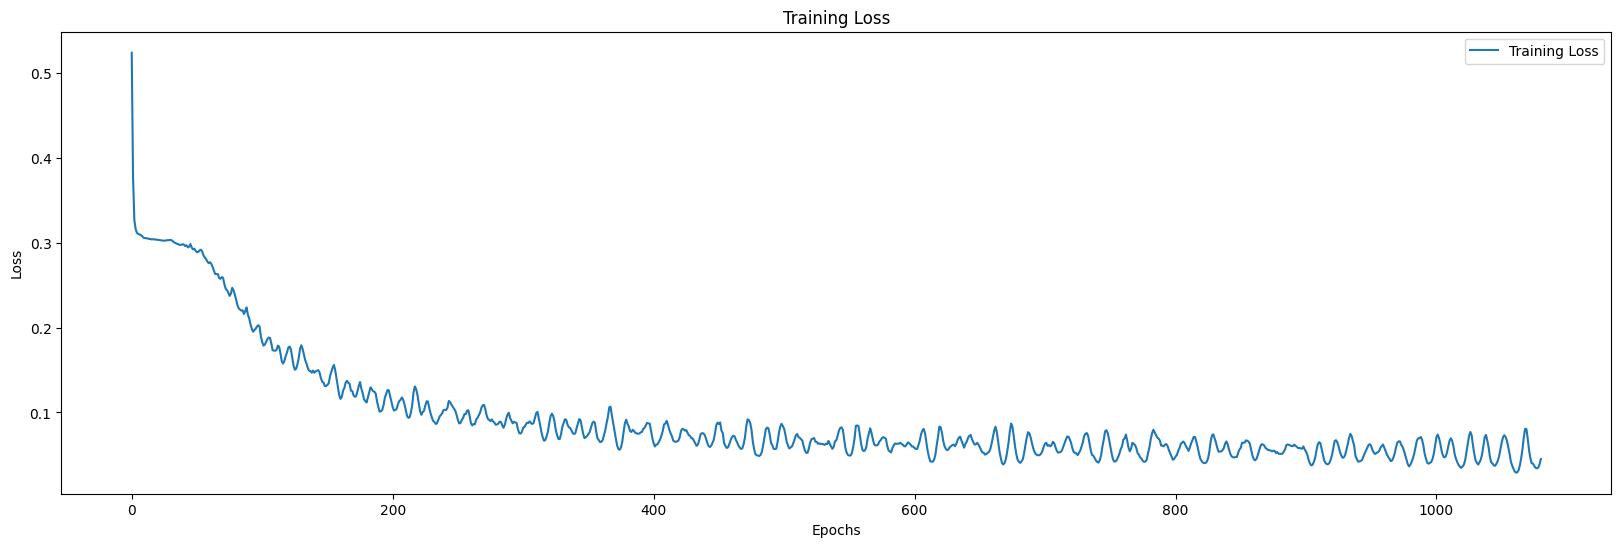

In [12]:
# Plot the loss curves
plt.figure(figsize=(20, 6))
plt.plot(losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

In [ ]:
def make_output(start_idx):
    model.eval()
    indices = torch.arange(start_idx, start_idx+img_size+len(keep_labels)).to(device)
    inputs = positional_encoding(indices, embedd_dim)
    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
    img = predicted[:img_size].cpu().numpy().reshape(28, 28)
    label = predicted[img_size:img_size+10].cpu().numpy()
    label = np.argmax(label)
    return img, label

start = num_entries - 2
# start = 0
for idx in range(start, start+4):
    seq_start = idx * 1024
    img, label = make_output(seq_start)
    plt.imshow(img, cmap='gray')
    plt.show()
    print(label)

In [ ]:
item = 0
seq_start = item * 1024
img, label = make_output(seq_start)
plt.imshow(img, cmap='gray')
plt.show()
print(label)

item = 80
seq_start = item * 1024
img, label = make_output(seq_start)
plt.imshow(img, cmap='gray')
plt.show()
print(label)

In [ ]:
item = 0
image = images[item]
label = labels[item]
plt.imshow(image, cmap='gray')
plt.show()
print(label)

item = 80
image = images[item]
label = labels[item]
plt.imshow(image, cmap='gray')
plt.show()
print(label)

In [ ]:
#before conditioning
print('before conditioning')
seq_start = 80 * 1024
img, label = make_output(seq_start)
plt.imshow(img, cmap='gray')
plt.show()
print(label)

print('-'*80)

#now let's teach the model that the correct pixels for item 80 are the pixels of item 0
#then we'll see if the model changes the corresponding label of 80 from "1" to "0"

target = images[0].flatten()
target = torch.tensor(target, dtype=torch.uint8).to(device)
inputs = torch.arange(seq_start, seq_start + img_size).to(device)
inputs = positional_encoding(inputs, embedd_dim)

criterion = nn.CrossEntropyLoss()
conditioning_optimizer = optim.SGD(model.parameters())
model.train()
num_conditioning_steps = 100

for step in range(num_conditioning_steps):
    conditioning_optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, target)
    loss.backward()
    conditioning_optimizer.step()
    print(f"Conditioning Step {step+1}/{num_conditioning_steps}, Loss: {loss.item():.6f}")
    img, label = make_output(seq_start)
    plt.imshow(img, cmap='gray')
    plt.show()
    print(label)

print('-'*80)
print('after conditioning')
img, label = make_output(seq_start)
plt.imshow(img, cmap='gray')
plt.show()
print(label)

## Save

In [ ]:
# Define a function to save the model checkpoint
def save_checkpoint(model, optimizer, epoch, loss, filename="checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch} with loss {loss:.4f}")

save_checkpoint(model, optimizer, epoch+1, avg_loss, filename=f"mnist/checkpoint_epoch_{epoch+1}.pth")

In [ ]:
def load_checkpoint(model, optimizer, filename="checkpoint.pth"):
    checkpoint = torch.load(filename, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded: epoch {epoch}, loss {loss:.4f}")
    return epoch, loss

model = AUNNModel(embedd_dim, output_dim, num_layers, hidden_dim).to(device)
optimizer = optim.AdamW(model.parameters())
start_epoch, start_loss = load_checkpoint(model, optimizer, filename="mnist/checkpoint_epoch_1000.pth")

## Condition

In [ ]:
N = len(text) - 1

#see value before conditioning
generated_text = generate_text(model, start_index=N+1, length=150)
print("Original Text:")
print(generated_text) # "|a..."
print("")

#conditioning the model
conditioning_targets = ['c','a','b']  # Desired tokens at N+1 and N+2, this also works if you use "|b"
conditioning_positions = [N+2, N+7, N+12]

conditioning_target_indices = [token_to_id[token] for token in conditioning_targets]
positions_tensor = torch.tensor(conditioning_positions, dtype=torch.float32).to(device)
targets_tensor = torch.tensor(conditioning_target_indices, dtype=torch.long).to(device)
inputs = positional_encoding(positions_tensor, embedd_dim).to(device)

criterion = nn.CrossEntropyLoss()
conditioning_optimizer = optim.SGD(model.parameters(), lr=1e-3)
model.train()
num_conditioning_steps = 10

for step in range(num_conditioning_steps):
    conditioning_optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets_tensor)
    loss.backward()
    conditioning_optimizer.step()
    print(f"Conditioning Step {step+1}/{num_conditioning_steps}, Loss: {loss.item():.6f}")

#see value after conditioning
generated_text = generate_text(model, start_index=N+1, length=150)
print("")
print("Text after conditioning:")
print(generated_text) # "|ccc|..." shows conditioning works because of N+3 and N+4